# Vault Setup in Kubernetes (EKS)

## Summary of solutions

* Setup a Kind cluster
* Install Vault Helm Chart
* Deploy Vault Dev Mode in Kubernetes
* Configurations (K8 Auth, policy, Static and Dynamic Secret Engines)
* Retrieve static secrets
* Retrieve dynamic secrets - PKI, Database Creds

![image.png](./images/vault-k8-demo.png)


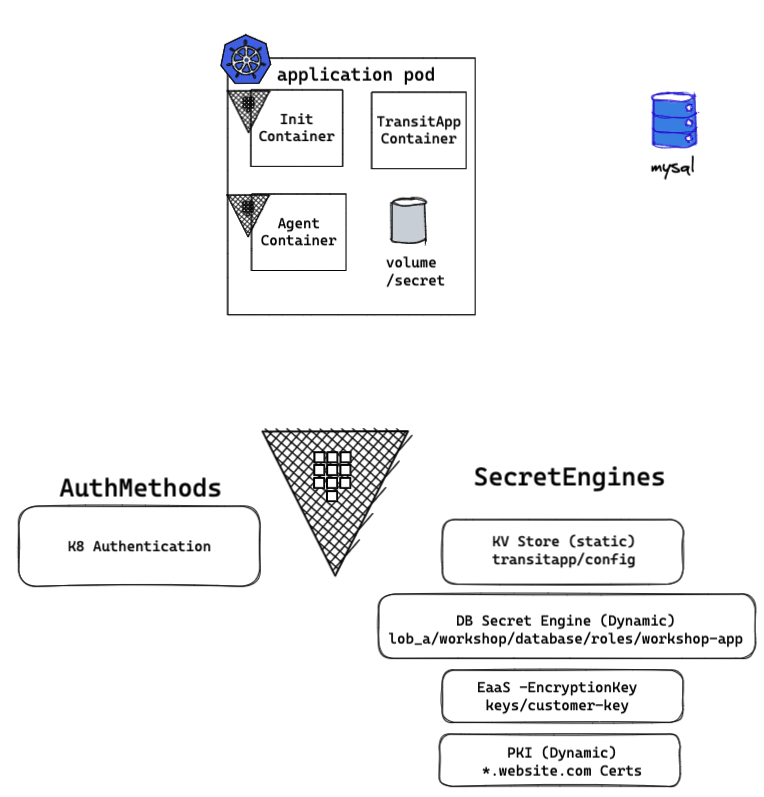

## Lets setup a Kind Cluster

In [ ]:
kind create cluster --name vault --image kindest/node:v1.21.1 --config kind.yml

In [ ]:
kind get clusters

In [ ]:
kubectl get pods

In [ ]:
helm repo add hashicorp https://helm.releases.hashicorp.com
helm search repo hashicorp/vault -l

In [ ]:
helm install vault hashicorp/vault -f ./values.yaml

In [ ]:
kubectl get pods

In [ ]:
export VAULT_TOKEN=root
export VAULT_ADDR=http://localhost:8200

In [ ]:
kubectl port-forward service/vault 8200:8200 &>/dev/null &

## Setup Secret Engines

### KV Secret Engine

In [ ]:
# We started Vault in dev mode, this will enable the kv secret engine by default in the /secret path
vault kv put secret/transitapp/config username='thisismyusername' password='thisismypassword'
vault kv get -format=json secret/transitapp/config | jq ".data.data"

### Setup PKI Secret Engine

In [ ]:
vault secrets enable pki

In [ ]:
# configure lease ttl on certificates
vault secrets tune -max-lease-ttl=8760h pki

In [ ]:
## Configure CA
vault write pki/root/generate/internal \
    common_name=my-org.com \
    ttl=8760h

In [ ]:
vault write pki/roles/websiterole \
    allowed_domains=website.com \
    allow_subdomains=true \
    max_ttl=72h

### lets test issuing a certificate

In [ ]:
vault write pki/issue/websiterole \
    common_name=www.website.com

### Configure Transit Secret Engine (Encryption as a Service)

In [ ]:
vault secrets enable -path=lob_a/workshop/transit transit

In [ ]:
vault write -f lob_a/workshop/transit/keys/customer-key

## Deploy Database

In [ ]:
kubectl apply -f ./deploy-msqlservice.yaml

In [ ]:
kubectl get pods

In [ ]:
# set mysql alias
mysql_service=$(kubectl get pod --selector='app=mysql' --output='jsonpath={.items[0].metadata.name}')
alias mysql="kubectl exec -it $mysql_service -- mysql"

In [ ]:
#Display existing database users and databases
mysql -u root -p'password' -e "select user from mysql.user;"
mysql -u root -p'password' -e "show databases"

## Deploy Vault Database Secret Engine

In [ ]:
vault secrets enable -path=lob_a/workshop/database database

**Configure Vault `workshop-app` role**

In [ ]:
vault write lob_a/workshop/database/config/ws-mysql-database \
    plugin_name=mysql-database-plugin \
    connection_url="{{username}}:{{password}}@tcp(mysql:3306)/" \
    allowed_roles="workshop-app","db-user-static" \
    username="root" \
    password="password"

In [ ]:
vault write lob_a/workshop/database/roles/workshop-app \
    db_name=ws-mysql-database \
    creation_statements="CREATE USER '{{name}}'@'%' IDENTIFIED BY '{{password}}';GRANT ALL ON my_app.* TO '{{name}}'@'%';" \
    default_ttl="1h" \
    max_ttl="24h"

In [ ]:
# lets test if we can retrieve dynamic creds from the database
vault read lob_a/workshop/database/creds/workshop-app

## Setup Vault Kubernetes Auth Method

In [ ]:
vault auth enable kubernetes

In [ ]:
VAULT_HELM_SECRET_NAME=$(kubectl get secrets --output=json | jq -r '.items[].metadata | select(.name|startswith("vault-token-")).name')
# kubectl describe secret $VAULT_HELM_SECRET_NAME
TOKEN_REVIEW_JWT=$(kubectl get secret $VAULT_HELM_SECRET_NAME --output='go-template={{ .data.token }}' | base64 --decode)
KUBE_CA_CERT=$(kubectl config view --raw --minify --flatten --output='jsonpath={.clusters[].cluster.certificate-authority-data}' | base64 --decode)
KUBE_HOST=$(kubectl get services --field-selector metadata.name=kubernetes -o jsonpath='{.items[].spec.clusterIP}')

# echo $VAULT_HELM_SECRET_NAME
# echo $TOKEN_REVIEW_JWT
# echo $KUBE_CA_CERT
# echo $KUBE_HOST

vault write auth/kubernetes/config \
        kubernetes_host="https://$KUBE_HOST:443" \
        token_reviewer_jwt=$TOKEN_REVIEW_JWT \
        kubernetes_ca_cert="$KUBE_CA_CERT" \
        issuer="https://kubernetes.default.svc.cluster.local" \
        disable_iss_validation=true

In [ ]:
vault read /auth/kubernetes/config

### Setup Kubernetes Auth Method Role

In [ ]:
vault write auth/kubernetes/role/transitapp \
        bound_service_account_names=transitapp \
        bound_service_account_namespaces=default \
        policies=transitapp_policy \
        ttl=24h

## Configure Vault Policy for transitapp role


In [ ]:
vault policy write transitapp_policy - <<EOF

path "pki/issue/websiterole" {
  capabilities = ["create","update"]
}

path "secret/data/transitapp/config" {
  capabilities = ["read"]
}

path "lob_a/workshop/transit/encrypt/customer-key" {
  capabilities = ["update"]
}

path "lob_a/workshop/transit/decrypt/customer-key" {
  capabilities = ["update"]
}


path "lob_a/workshop/database/creds/workshop-app" {
  capabilities = ["read","update"]
}

EOF

## Deploy Transit App

In [ ]:
kubectl delete deployment transitapp
kubectl apply -f ./deploy-transitapp.yaml

In [ ]:
kubectl get pods

In [ ]:
kubectl port-forward service/transitapp 8080:5000 &>/dev/null &

got to browser https://localhost:8080

## Where are the Secrets stored?

In [ ]:
## Get mycerts.txt secrets
kubectl exec -it $(kubectl get pod --selector='app=transitapp' --output='jsonpath={.items[0].metadata.name}') -- cat /config/cert/ca.pem

In [ ]:
## Get mycerts.txt secrets
kubectl exec -it $(kubectl get pod --selector='app=transitapp' --output='jsonpath={.items[0].metadata.name}') -- cat /config/cert/cert.pem

In [ ]:
## Get mycerts.txt secrets
kubectl exec -it $(kubectl get pod --selector='app=transitapp' --output='jsonpath={.items[0].metadata.name}') -- cat /config/cert/key.pem

## Clean Up

In [ ]:
kubectl delete deployments transitapp

In [ ]:
kubectl delete deployments mysql

In [ ]:
helm delete vault

In [ ]:
kind delete cluster --name vault